# Deep Mario with Random Forest
Actualizado al 25/Nov con 35 columns

In [228]:
import numpy as np
import pandas as pd
import networkx as nx
import collections 
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, RepeatedKFold, GridSearchCV, ParameterGrid
import multiprocessing
import warnings
import sklearn
print(sklearn.__version__) 


1.0.1


In [229]:
df = pd.read_csv("../results/results_BarabasiFog_X/samples.csv")
print(len(df))
print(len(df.columns))

40004
35


In [231]:
df.Sim

0          0
1          0
2          0
3          0
4          0
        ... 
39999    133
40000    133
40001    133
40002    133
40003    133
Name: Sim, Length: 40004, dtype: int64

In [210]:
#dummies
actions_labels = ["replicate", "migrate", "none", "small", "medium","large","undeploy"]

actions = np.arange(len(actions_labels)) #dummies
df["Action"] = df["Action"].map(lambda x:actions_labels.index(x))
df["CurrentFlavour"] = df["CurrentFlavour"].map(lambda x:actions_labels.index(x))

In [211]:
df.head()

,Sim,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,...,NextAvgRequests,NextSumLat,NextAvgLat,DstHWTotal,NextHWUsed,NextUtilization,DstDegree,DstCentrality,DstConnectedUsers,Reward
0,0,6,1,3,5,1,0,0,0,0.0,...,0.0,0,0.0,20.0,13,0.35,1,0.010101,0,1.0
1,0,6,1,4,10,2,0,0,0,0.0,...,0.0,0,0.0,20.0,14,0.30,1,0.010101,0,1.0
2,0,6,1,3,5,1,0,0,0,0.0,...,0.0,0,0.0,40.0,34,0.15,1,0.010101,0,1.0
3,0,6,1,4,10,2,0,0,0,0.0,...,0.0,0,0.0,40.0,26,0.35,1,0.010101,0,1.0
4,0,6,1,5,20,5,0,0,0,0.0,...,0.0,0,0.0,40.0,26,0.35,1,0.010101,0,1.0


In [212]:
# UNIT TESTs
# El reward positivo de una Action-undeploy no puede realizarse si hay peticiones futuras
assert len(df.loc[(df["Action"]==6) & (df["Reward"]==1) & (df["NextSumRequests"]>0)])==0

# No puede haber ninguna acción diferente al undeploy con reward positivo si no recibe peticiones
assert len(df.loc[(df["Action"]!=6) & (df["SumRequests"]==0) & (df["Reward"]>0)])==0

# No puede haber ninguna acción de migración positiva cuando hay más de un canal
assert len(df.loc[(df["Action"]==1) & (df["DifReqChannels"]>1) & (df["Reward"]>0)])==0

# No puede haber ninguna acción de replicación positiva cuando hay solo un canal
assert len(df.loc[(df["Action"]==0) & (df["DifReqChannels"]==1) & (df["Reward"]>0)])==0

In [213]:
df = df.drop(columns="Sim") # debug columns

In [235]:
print(list(df.columns))
print(len(df.columns))

['Sim', 'Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'NextSupportedRequests', 'NextHWReq', 'NextDifReqChannels', 'NextTotReqChannels', 'NextSumRequests', 'NextAvgRequests', 'NextSumLat', 'NextAvgLat', 'DstHWTotal', 'NextHWUsed', 'NextUtilization', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']
35


In [236]:
# Our state is based on a set of columns
# We can remove columns with NEXT* name
state_cols = [x for x in df.columns if "Next" not in x]
print(state_cols)
print(len(state_cols))

['Sim', 'Action', 'App', 'CurrentFlavour', 'SupportedRequests', 'HWReq', 'DifReqChannels', 'TotReqChannels', 'SumRequests', 'AvgRequests', 'SumLat', 'AvgLat', 'HWTotal', 'HWUsed', 'Utilization', 'Degree', 'Centrality', 'ConnectedUsers', 'DstHWUsed', 'DstUtilization', 'DstHWTotal', 'DstDegree', 'DstCentrality', 'DstConnectedUsers', 'Reward']
25


In [216]:
df = df.loc[:,state_cols]
df.head()

,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,SumLat,...,Degree,Centrality,ConnectedUsers,DstHWUsed,DstUtilization,DstHWTotal,DstDegree,DstCentrality,DstConnectedUsers,Reward
0,6,1,3,5,1,0,0,0,0.0,0,...,1,0.010101,0,0,0.0,20.0,1,0.010101,0,1.0
1,6,1,4,10,2,0,0,0,0.0,0,...,1,0.010101,0,0,0.0,20.0,1,0.010101,0,1.0
2,6,1,3,5,1,0,0,0,0.0,0,...,1,0.010101,0,0,0.0,40.0,1,0.010101,0,1.0
3,6,1,4,10,2,0,0,0,0.0,0,...,1,0.010101,0,0,0.0,40.0,1,0.010101,0,1.0
4,6,1,5,20,5,0,0,0,0.0,0,...,1,0.010101,0,0,0.0,40.0,1,0.010101,0,1.0


In [217]:
X_train, X_test, y_train, y_test = train_test_split(
                                        df.drop(columns = "Reward"),
                                        df['Reward'],
                                        random_state = 0)
print(len(X_train))
print(len(X_test))
print(len(y_test))

30003
10001
10001


In [218]:
#Training                                    
model = RandomForestRegressor(
            n_estimators = 10,
            criterion    = 'squared_error',
            max_depth    = None,
            max_features = 'auto',
            oob_score    = False,
            n_jobs       = -1,
            random_state = 123
         )

model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=123)

In [219]:
importancia_predictores = pd.DataFrame(
                            {'predictor': df.drop(columns = "Reward").columns,
                             'importancia': model.feature_importances_}
                            )

importancia_predictores.sort_values('importancia', ascending=False)


,predictor,importancia
0,Action,0.481301
6,TotReqChannels,0.112902
5,DifReqChannels,0.098880
10,AvgLat,0.069468
8,AvgRequests,0.049421
7,SumRequests,0.032905
22,DstConnectedUsers,0.025367
9,SumLat,0.015435
20,DstDegree,0.015182
3,SupportedRequests,0.011956


In [220]:
from sklearn.inspection import permutation_importance
importancia = permutation_importance(
                estimator    = model,
                X            = X_train,
                y            = y_train,
                n_repeats    = 5,
                scoring      = 'neg_root_mean_squared_error',
                n_jobs       = multiprocessing.cpu_count() - 1,
                random_state = 123
             )

# Se almacenan los resultados (media y desviación) en un dataframe
df_importancia = pd.DataFrame(
                    {k: importancia[k] for k in ['importances_mean', 'importances_std']}
                 )
df_importancia['feature'] = X_train.columns
df_importancia.sort_values('importances_mean', ascending=False)

,importances_mean,importances_std,feature
0,0.527869,0.000587,Action
10,0.194052,0.000953,AvgLat
6,0.183780,0.000422,TotReqChannels
5,0.157141,0.000860,DifReqChannels
9,0.102576,0.001012,SumLat
22,0.099550,0.001693,DstConnectedUsers
20,0.092753,0.000961,DstDegree
21,0.090442,0.001058,DstCentrality
7,0.085784,0.000631,SumRequests
8,0.063802,0.000435,AvgRequests


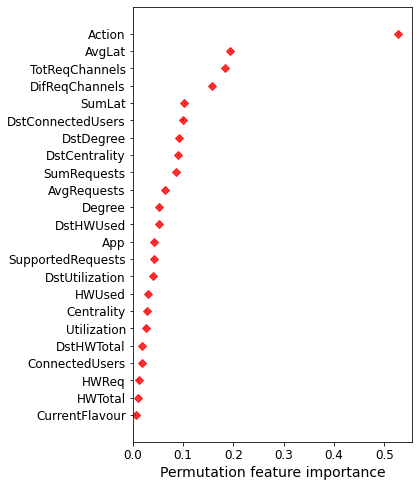

In [233]:
# Gráfico
fig, ax = plt.subplots(figsize=(5, 8))
df_importancia = df_importancia.sort_values('importances_mean', ascending=True)
ax.barh(
    df_importancia['feature'],
    df_importancia['importances_mean'],
    xerr=df_importancia['importances_std'],
    align='center',
    alpha=0
)
ax.plot(
    df_importancia['importances_mean'],
    df_importancia['feature'],
    marker="D",
    linestyle="",
    alpha=0.8,
    color="r"
)
#ax.set_title('Importancia de los predictores (train)')
ax.set_xlabel('Permutation feature importance');
fig.savefig("importanceFeature.pdf", dpi=400, bbox_inches='tight')

# Evaluation 

In [222]:
from sklearn import metrics
y_pred = model.predict(X_test)
#X_train, X_test, y_train, y_test
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 0.03837249694363897
Mean Squared Error: 0.01921036659484161
Root Mean Squared Error: 0.1386014667845965


## TESTING

In [223]:
dtest = df.loc[y_test.index]
dtest.head()

,Action,App,CurrentFlavour,SupportedRequests,HWReq,DifReqChannels,TotReqChannels,SumRequests,AvgRequests,SumLat,...,Degree,Centrality,ConnectedUsers,DstHWUsed,DstUtilization,DstHWTotal,DstDegree,DstCentrality,DstConnectedUsers,Reward
23039,1,3,4,20,4,1,2,5,2.500000,18,...,1,0.010101,0,5,0.25,20.0,1,0.010101,0,0.0
26841,6,2,5,30,3,0,0,0,0.000000,0,...,1,0.010101,0,0,0.00,30.0,1,0.010101,0,1.0
4214,6,2,5,30,3,0,0,0,0.000000,0,...,1,0.010101,0,0,0.00,40.0,1,0.010101,0,1.0
8198,0,3,4,20,4,1,1,11,11.000000,16,...,1,0.010101,0,3,0.10,20.0,1,0.010101,0,0.0
19733,2,1,3,5,1,3,6,35,5.833333,20,...,34,0.343434,0,0,0.00,60.0,34,0.343434,0,0.0


In [224]:
from collections import Counter
actions_labels = ["replicate", "migrate", "none", "small", "medium","large","undeploy"]
actions_rcat = range(len(actions_labels))
acts = collections.defaultdict(list)
col = df.columns[:-1]
f = open("results_RF.csv","w")
for act_ix,act in enumerate(actions_labels):
    dt = dtest.loc[(dtest["Action"]==act_ix) & (dtest["Reward"]>0)]
    print("Action,%s,%i"%(act,len(dt)))
    f.write("Action,%s,%i\n"%(act,len(dt)))
    counter = Counter()
    for e,(ix,row) in enumerate(dt.iterrows()):
        vals = []
        for i in actions_rcat:
            dftest = pd.DataFrame(columns=list(col))
            row["Action"] = i
            dftest.loc[0]= row
            forecasting = model.predict(X = dftest)
            vals.append(forecasting[0])

        ix_max = np.argmax(vals)
        
        
        counter[actions_labels[ix_max]]+=1
#        if e == 2:
#            break
    for (action,v) in counter.items():
        print("%s,%i,%0.4f"%(action,v,v/float(len(dt))))
        f.write("%s,%i,%0.4f\n"%(action,v,v/float(len(dt))))

f.close()

Action,replicate,61
replicate,61,1.0000
Action,migrate,825
medium,44,0.0533
migrate,608,0.7370
small,121,0.1467
large,50,0.0606
none,2,0.0024
Action,none,234
small,56,0.2393
medium,45,0.1923
none,27,0.1154
large,86,0.3675
migrate,19,0.0812
replicate,1,0.0043
Action,small,96
large,4,0.0417
small,44,0.4583
migrate,33,0.3438
medium,13,0.1354
replicate,2,0.0208
Action,medium,145
small,41,0.2828
large,25,0.1724
none,6,0.0414
migrate,42,0.2897
medium,26,0.1793
replicate,5,0.0345
Action,large,218
large,43,0.1972
migrate,75,0.3440
replicate,22,0.1009
none,6,0.0275
small,52,0.2385
medium,20,0.0917
Action,undeploy,2839
undeploy,2839,1.0000


In [226]:
from collections import defaultdict
import copy
actions_labels = ["replicate", "migrate", "none", "small", "medium","large","undeploy"]
path_res = "results_RF.csv"
vals = defaultdict(list)
res = pd.read_csv(path_res,header=None)
first = False
actions_no_used = copy.copy(actions_labels)
for i,r in res.iterrows():
    if r[0]=="Action":
        if first:
            for action in actions_no_used:
                vals[action].append(0)
            actions_no_used = copy.copy(actions_labels)
        ix = actions_labels.index(r[1])        
        rate = r[2]
        first = True
    else:
        action = r[0]
        perc = r[2]
        vals[action].append(perc)
        actions_no_used.remove(action)
for action in actions_no_used:
    vals[action].append(0)
print(vals)

defaultdict(<class 'list'>, {'replicate': [1.0, 0, 0.0043, 0.0208, 0.0345, 0.1009, 0], 'migrate': [0, 0.737, 0.0812, 0.3438, 0.2897, 0.344, 0], 'none': [0, 0.0024, 0.1154, 0, 0.0414, 0.0275, 0], 'small': [0, 0.1467, 0.2393, 0.4583, 0.2828, 0.2385, 0], 'medium': [0, 0.0533, 0.1923, 0.1354, 0.1793, 0.0917, 0], 'large': [0, 0.0606, 0.3675, 0.0417, 0.1724, 0.1972, 0], 'undeploy': [0, 0, 0, 0, 0, 0, 1.0]})


/var/folders/hd/b3xdbhj91fj7d7_gq2f0v1h40000gn/T/ipykernel_8861/2654830048.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(yticks, size=12)


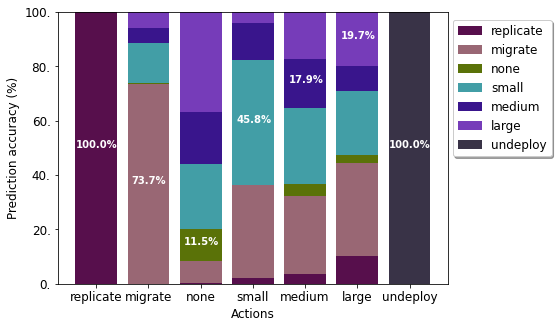

In [227]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors

font_size = 12
font_size_ax = 14
plt.rc('xtick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=font_size)    # fontsize of the tick labels
plt.rc('legend', fontsize=font_size) 
plt.rc('axes', titlesize=font_size_ax)     # fontsize of the axes title
plt.rc('axes', labelsize=font_size_ax) 

colors_list = ["#570f4c","#996774","#5A7208","#429ea6","#39158c","#763CB9","#393347"]
# create data
actions_labels = ["replicate", "migrate", "none", "small", "medium","large","undeploy"]
acc = np.zeros(len(actions_labels))
fig, ax = plt.subplots(figsize=(7,5))

for ix,action in enumerate(actions_labels):
    y = np.array(vals[action])
    rects = plt.bar(actions_labels, y,bottom=acc, color=colors_list[ix])
    rect = rects[ix]
    k = 10.0
    if len("%2.1f%%"%(y[ix]*100.0))>5: k = 80.0
    ax.text(rect.get_x()+rect.get_width()/k, acc[ix]+rect.get_height()/2.,
                "%2.1f%%"%(y[ix]*100.0), rotation=0,color="white",weight="bold")
    acc += y
yticks = ax.get_yticks()
yticks = ["0.","20.", "40.", "60.", "80.", "100."]
ax.set_yticklabels(yticks, size=12)
plt.xlabel("Actions", size=12)
plt.ylabel("Prediction accuracy (%)", size=12)
plt.legend(actions_labels,loc='center right', bbox_to_anchor=(1.28, 0.72),
          fancybox=True, shadow=True, ncol=1)
plt.show()
fig.savefig("randomForestByAction.pdf", dpi=400, bbox_inches='tight')